### 0.78947

- new :: 
- 연속값 Fare를 qcut으로 범주화
- rfc 파라미터 튜닝

### 사용 라이브러리 

In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# import csv
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

import warnings 
warnings.filterwarnings('ignore')

### Data set 확인

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/플렉싱크/Titanic/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/플렉싱크/Titanic/test.csv')

In [8]:
# train 

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
train.shape

(891, 12)

In [10]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [12]:
# test 

test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [13]:
test.shape

(418, 11)

In [14]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [16]:
# train 결측값
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [17]:
# test 결측값
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### 데이터 전처리

#### 1. 결측값 처리

- Age -> 평균 29.69

In [18]:
train['Age'] = train['Age'].fillna(29.69)     # train
test['Age'] = test['Age'].fillna(29.69)   # test

- Embarked -> 최빈값 S(0)

In [19]:
train['Embarked'] = train['Embarked'].fillna('S')

- Fare -> 최빈값 8.05

In [20]:
fare = train['Fare']
fare.mode()

0    8.05
dtype: float64

In [21]:
test['Fare'] = test['Fare'].fillna(8.05)

#### 2. 변수 생성

In [22]:
# age_gr / married / f_nm / f_ox / fare_gr

- Age > Age_gr

In [23]:
def age_gr(x):
    if x < 5 :
       return 'very young'
    if 5<=x<10:
       return 'young'
    if 10<=x<16:
       return 'children'
    if 16<=x<20:
       return 's_adult'    # 16세~ 성인 간주 
    if 20<=x<30:
       return '20s'
    if 30<=x<40:
       return '30s'
    if 40<=x<50:
       return '40s'
    if 50<=x<60:
       return '50s'
    if 60<=x<70:
       return '60s'
    if 70<=x<80:
       return '70s'
    if 80<=x<90:
       return '80s'


In [24]:
train['Age_gr'] = train['Age'].apply(lambda x:age_gr(x))
test['Age_gr'] = test['Age'].apply(lambda x:age_gr(x))

- SibSp + Parch > F_nm

In [25]:
train['F_nm'] = train['SibSp'] + train['Parch']
test['F_nm'] = test['SibSp'] + test['Parch']

- F_nm > F_ox

In [26]:
def f_ox(x):
    if x == 0:
        return 0
    if x >= 1:
        return 1   

In [27]:
train['F_ox'] = train['F_nm'].apply(lambda x: f_ox(x))
test['F_ox'] = test['F_nm'].apply(lambda x: f_ox(x))

- **Fare > Fare_gr**

In [28]:
train['Fare'] = pd.qcut(train['Fare'], 5)
test['Fare'] = pd.qcut(test['Fare'], 5)

train['Fare'].value_counts()

(7.854, 10.5]        184
(21.679, 39.688]     180
(-0.001, 7.854]      179
(39.688, 512.329]    176
(10.5, 21.679]       172
Name: Fare, dtype: int64

In [29]:
train['Fare'] = train['Fare'].astype('category').cat.codes
test['Fare'] = test['Fare'].astype('category').cat.codes

train['Fare'].value_counts()

1    184
3    180
0    179
4    176
2    172
Name: Fare, dtype: int64

- Name > Married

In [30]:
train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_gr,F_nm,F_ox
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,0,NaN,S,20s,1,1


In [31]:
# 미혼(0)
# Miss      
# Master  
# Rev   
# Mlle  


# 기혼(1)
# Mr        
# Mrs       


# X 불명(9)
# Don           
# Mme           
# Col          
# Capt          
# the Countess  
# Jonkgeer      
# Dr            
# Ms            
# Major         
# Lady          
# Sir  


In [32]:
train['Name'] = train['Name'].str.split(',').str[1]
train['Name'] = train['Name'].str.split('.').str[0]

In [33]:
test['Name'] = test['Name'].str.split(',').str[1]
test['Name'] = test['Name'].str.split('.').str[0]

In [34]:
my = [' Mr', ' Mrs']
mn = [' Miss', ' Master', ' Rev', ' Mlle']

train['Married'] = train['Name'].apply(lambda x : 0 if x in my else 1 if x in mn else 9)  
test['Married'] = test['Name'].apply(lambda x : 0 if x in my else 1 if x in mn else 9)      

#### 문자열 -> 숫자형으로 인코딩

In [35]:
# sex, embarked / age_gr 레이블 인코딩 
 
train['Sex'] = LabelEncoder().fit_transform(train.Sex)  # 0 여성 / 1 남성 
test['Sex'] = LabelEncoder().fit_transform(test.Sex)

train['Embarked'] = LabelEncoder().fit_transform(train.Embarked)
test['Embarked'] = LabelEncoder().fit_transform(test.Embarked)

train['Age_gr'] = LabelEncoder().fit_transform(train.Age_gr)
test['Age_gr'] = LabelEncoder().fit_transform(test.Age_gr)
train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_gr,F_nm,F_ox,Married
0,1,0,3,Mr,1,22.0,1,0,A/5 21171,0,NaN,2,0,1,1,0
1,2,1,1,Mrs,0,38.0,1,0,PC 17599,4,C85,0,1,1,1,0
2,3,1,3,Miss,0,26.0,0,0,STON/O2. 3101282,1,NaN,2,0,0,0,1
3,4,1,1,Mrs,0,35.0,1,0,113803,4,C123,2,1,1,1,0
4,5,0,3,Mr,1,35.0,0,0,373450,1,NaN,2,1,0,0,0


#### 필요없는 변수 drop

In [36]:
# cabin, ticket, Name, Age, SibSp, Parch

train = train.drop(['PassengerId', 'SibSp', 'Parch', 'Cabin', 'Ticket', 'Name','Age'], axis=1)
test = test.drop(['Cabin', 'SibSp', 'Parch','Ticket','Name', 'Age'], axis=1)

In [37]:
train.head()

,Survived,Pclass,Sex,Fare,Embarked,Age_gr,F_nm,F_ox,Married
0,0,3,1,0,2,0,1,1,0
1,1,1,0,4,0,1,1,1,0
2,1,3,0,1,2,0,0,0,1
3,1,1,0,4,2,1,1,1,0
4,0,3,1,1,2,1,0,0,0


In [38]:
test.head()

,PassengerId,Pclass,Sex,Fare,Embarked,Age_gr,F_nm,F_ox,Married
0,892,3,1,1,1,1,0,0,0
1,893,3,0,0,2,2,1,1,0
2,894,2,1,1,1,4,0,0,0
3,895,3,1,1,2,0,0,0,0
4,896,3,0,2,2,0,2,1,0


### 변수 간 상관관계

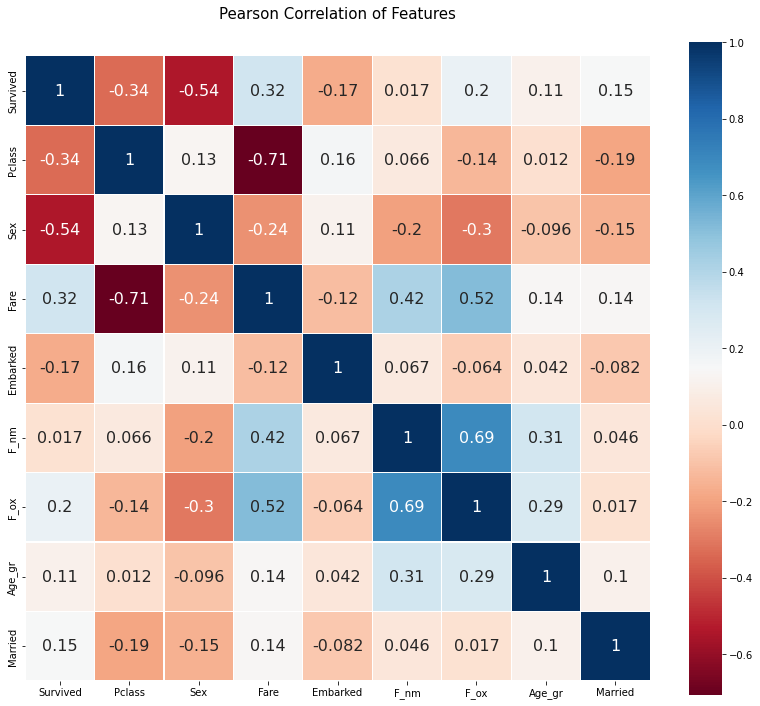

In [39]:
heatmap_data = train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'F_nm', 'F_ox', 'Age_gr', 'Married']] 

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 16})

del heatmap_data

#### 변수 간 관계

In [40]:
# sns.pairplot(train,diag_kind='hist')
# plt.show()

In [41]:
# import warnings 
# warnings.filterwarnings('ignore')

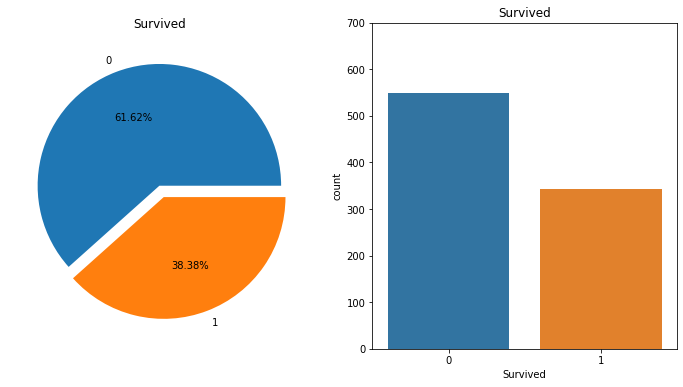

In [42]:
f,ax=plt.subplots(1,2,figsize=(12,6))

train['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.2f%%',ax=ax[0])
ax[0].set_title('Survived')
ax[0].set_ylabel('')

sns.countplot('Survived',data=train,ax=ax[1])
ax[1].set_title('Survived')
plt.ylim(0,700)
plt.show()

[Text(0.5, 1.0, 'Fare')]

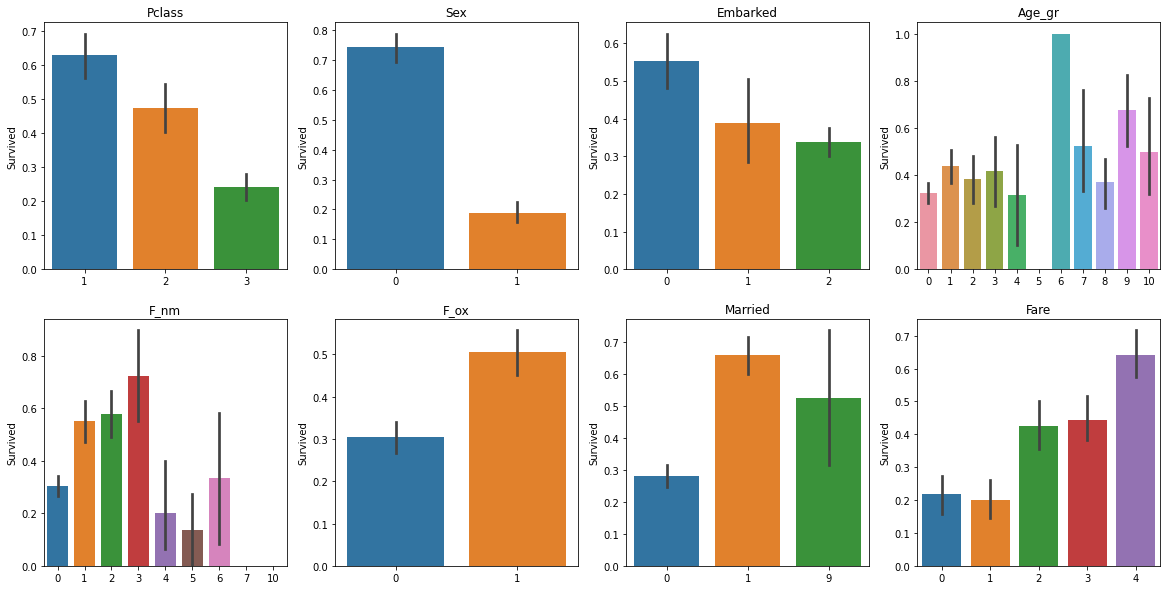

In [43]:
# 변수별 평균 생존률

fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2,4)
fig.set_size_inches(20,10)

sns.barplot(x='Pclass', y='Survived',data= train, ax=ax1)
sns.barplot(x='Sex', y='Survived',data= train, ax=ax2)
sns.barplot(x='Embarked', y='Survived',data= train, ax=ax3)
sns.barplot(x='Age_gr', y='Survived',data= train, ax=ax4)
sns.barplot(x='F_nm', y='Survived',data= train, ax=ax5)
sns.barplot(x='F_ox', y='Survived',data= train, ax=ax6)
sns.barplot(x='Married', y='Survived',data= train, ax=ax7)
sns.barplot(x='Fare', y='Survived', data= train, ax=ax8)

ax1.set(xlabel='')
ax2.set(xlabel='')
ax3.set(xlabel='')
ax4.set(xlabel='')
ax5.set(xlabel='')
ax6.set(xlabel='')
ax7.set(xlabel='')
ax8.set(xlabel='')

ax1.set(title="Pclass")
ax2.set(title="Sex")
ax3.set(title="Embarked")
ax4.set(title="Age_gr")
ax5.set(title="F_nm")
ax6.set(title="F_ox")
ax7.set(title="Married")
ax8.set(title='Fare')



In [44]:
# sharey=True : y축 동일화 

### 다양한 분류 모델

In [45]:
train['Survived'].unique()

array([0, 1])

train, test split

In [46]:
X = train.iloc[:,1:].values
y = train['Survived']
X.shape, y.shape

((891, 8), (891,))

In [47]:
X_train = train.drop("Survived", axis=1)
Y_train = train["Survived"]
X_test  = test.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

In [48]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

79.91

In [49]:
coeff_df = pd.DataFrame(train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
6,F_ox,0.597758
2,Fare,0.193750
4,Age_gr,0.088012
7,Married,0.045797
3,Embarked,-0.223444
5,F_nm,-0.409010
0,Pclass,-0.610913
1,Sex,-2.575858


In [50]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

82.94

In [51]:
# KNN

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

82.38

In [52]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

77.78

In [53]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

# 76315

90.68

In [54]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

# 77033

90.68

In [55]:
# XGBoost

xgb = XGBClassifier()
xgb.fit(X_train, Y_train)
Y_pred = xgb.predict(X_test)
xgb.score(X_train, Y_train)
acc_xgb = round(xgb.score(X_train, Y_train) * 100, 2)
acc_xgb

# 77751

85.41

### 랜덤 포레스트

In [56]:
rfc = RandomForestClassifier(random_state=2021)
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2021,
 'verbose': 0,
 'warm_start': False}

In [57]:
params = {
    'n_estimators': [130],
    'max_depth': [2,3,5,10],
    'min_samples_leaf' :[1,5,8],
    'min_samples_split' : [2,3,5]
}
# n_estimator = 100
# max sample/ max feature 

In [58]:
grid_rfc = GridSearchCV(rfc, param_grid=params, scoring ='accuracy', cv=5 )
grid_rfc.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2021),
             param_grid={'max_depth': [2, 3, 5, 10],
                         'min_samples_leaf': [1, 5, 8],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [130]},
             scoring='accuracy')

In [59]:
# 땅!

In [60]:
# 1
print(grid_rfc.best_params_)
print(grid_rfc.best_score_)

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 130}
0.8283033080158182


In [61]:
best_clf = grid_rfc.best_estimator_

In [62]:
Y_pred = best_clf.predict(test.iloc[:,1:])

In [64]:
# submission = pd.DataFrame({
#         "PassengerId": test["PassengerId"],
#         "Survived": Y_pred
#     })
# submission.to_csv('6r.csv', index=False)

In [65]:
# 6. Fare (qcut=6)
# corr 0.26 -> 0.32
# xgv : 90.35 / 77990 > fix 

# 12. 파라미터 튜닝 
# {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 130}
# rfc 82.83 / 78947 > fix
